In [1]:


import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.cluster import KMeans
import scipy.stats
import os.path
import datetime
import winsound
from imblearn.over_sampling import SMOTE
import scipy.stats as stats
from scipy.stats import loguniform
import sys
from sklearn.model_selection import StratifiedShuffleSplit
import os
from scipy.stats import chi2_contingency
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_fscore_support
from imblearn.over_sampling import SVMSMOTE
from sklearn.metrics import precision_score, recall_score, f1_score
import os.path
from openpyxl import Workbook, load_workbook
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from scipy.stats import randint
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from scipy.stats import kendalltau
from scipy.stats import pearsonr
from sklearn.svm import SVC
from pandas_profiling import ProfileReport
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.stats import pointbiserialr
from sklearn.feature_selection import RFECV
from tabulate import tabulate
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = 'white'
np.set_printoptions(threshold=sys.maxsize, suppress=True)

In [2]:
# After cleaning my initial dataset I saved the data into CSV format again so the cleaned and aligned dataset can act like original source for the other researchers who want to use this dataset.
# Problem, is that saving it to CSV to not preserve datatypes, so I have to make them categorical again.
datatypes = {'business_area': str, 'sex': str, 'employment_status': str,
            'time': str, 'time_ESAW': str, 'severity': str, 'enterprise_size': str,
            'citizenship': str, 'profession_code': str, 'type_of_injury': str
            , 'injured_bodypart': str, 'workstation': str,
            'working_environment': str, 'working_process': str
            , 'specific_physical_activity': str,
            'material_agent_of_physical_act.': str,
            'deviation': str, 'material_agent_of_deviation': str
            , 'contact_mode_of_injury': str, 'material_agent_of_contact_mode': str, 'general_profession_code': str, 'month': str, 'weekofyear': str, 'dayofweek': str, 'material_agent_of_physical_act': str}

In [3]:
os.chdir('/Users/Mario/OneDrive/Desktop/Final code for thesis')
df = pd.read_csv("data.csv", dtype = datatypes, encoding='latin-1', index_col=0)
df = df.drop(columns= ['date', 'time', 'datetime', 'time_ESAW', 'lost_days', 'type_of_injury', 'injured_bodypart', 'general_profession_class', 'business_sector', 'severity'])

In [4]:
df.target.value_counts()

0    36304
1    12541
Name: target, dtype: int64

In [4]:
# --------------------------------------------------------------------------------
#TRAINING ON ALL FEATURES
# --------------------------------------------------------------------------------

nr_of_independent_var = len(df.columns) - 1
independent_var_names = [col for col in df.columns if col != 'target']

# Define the predictor and target variables
all_object_cols = list(df.select_dtypes(include=['object']).columns)
df = pd.get_dummies(df, columns=all_object_cols)

# Separate independent variables and dependent variable for train set
X = df.drop(columns=['target'])
y = df['target']

# Balance the target class using random over-sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale float64 variables
float_cols = X_train.select_dtypes(include='float64').columns.tolist()
scaler = MinMaxScaler(feature_range=(0,1))
X_train[float_cols] = scaler.fit_transform(X_train[float_cols])
X_test[float_cols] = scaler.transform(X_test[float_cols])


feat = 'all_features'

In [5]:
# --------------------------------------------------------------------------------
#TRAINING ON SIGNIFICANT FEATURES
# --------------------------------------------------------------------------------

""" df_copy = df.copy()

def encode_categorical(df, categorical_columns):
    le = LabelEncoder()
    for col in categorical_columns:
        df[col] = le.fit_transform(df[col])
    return df

categorical_columns = df.select_dtypes(include='object').columns.tolist()
df_encoded = encode_categorical(df, categorical_columns)

# Get the column names with 'int32' and 'int64' dtypes
int32_columns = df_encoded.select_dtypes(include='int32').columns.tolist()
int64_columns = df_encoded.select_dtypes(include='int64').columns.tolist()

# Combine the two lists to create the categorical_columns list
categorical_columns = int32_columns + int64_columns

def chi_squared_test(df, target, categorical_columns):
    significant_features = []
    for col in categorical_columns:
        contingency_table = pd.crosstab(df[col], df[target])
        chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
        
        if p_value < 0.05:
            significant_features.append(col)
    
    return significant_features

significant_chi2_features = chi_squared_test(df_encoded, 'target', categorical_columns)


def kendall_correlation(df, target, numerical_columns):
    significant_features = []
    for col in numerical_columns:
        kendall_tau, p_value = stats.kendalltau(df[col], df[target])
        
        if p_value < 0.05:
            significant_features.append(col)
    
    return significant_features

numerical_columns = df.select_dtypes(include='float64').columns.tolist()
significant_kendall_features = kendall_correlation(df, 'target', numerical_columns)

significant_features = significant_chi2_features + significant_kendall_features

df = df_copy[significant_features]

df.info()

nr_of_independent_var = len(df.columns) - 1
independent_var_names = [col for col in df.columns if col != 'target']

# Encode categorical features with no order
all_object_cols = list(df.select_dtypes(include=['object']).columns)
df = pd.get_dummies(df, columns=all_object_cols)

# Separate independent variables and dependent variable for train set
X = df.drop(columns=['target'])
y = df['target']

# Balance the target class using random over-sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale float64 variables
float_cols = X_train.select_dtypes(include='float64').columns.tolist()
scaler = MinMaxScaler(feature_range=(0,1))
X_train[float_cols] = scaler.fit_transform(X_train[float_cols])
X_test[float_cols] = scaler.transform(X_test[float_cols])

feat = 'significant_features' """

" df_copy = df.copy()\n\ndef encode_categorical(df, categorical_columns):\n    le = LabelEncoder()\n    for col in categorical_columns:\n        df[col] = le.fit_transform(df[col])\n    return df\n\ncategorical_columns = df.select_dtypes(include='object').columns.tolist()\ndf_encoded = encode_categorical(df, categorical_columns)\n\n# Get the column names with 'int32' and 'int64' dtypes\nint32_columns = df_encoded.select_dtypes(include='int32').columns.tolist()\nint64_columns = df_encoded.select_dtypes(include='int64').columns.tolist()\n\n# Combine the two lists to create the categorical_columns list\ncategorical_columns = int32_columns + int64_columns\n\ndef chi_squared_test(df, target, categorical_columns):\n    significant_features = []\n    for col in categorical_columns:\n        contingency_table = pd.crosstab(df[col], df[target])\n        chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)\n        \n        if p_value < 0.05:\n            significant_features.append(

In [6]:
# Balance the target class using random over-sampling
target_1 = y_train.value_counts()[1]

rs = 42
over_sampler = RandomOverSampler(random_state=rs)
X_train, y_train = over_sampler.fit_resample(X_train, y_train)
balancing_tech = 'ROS'

""" under_sampler = RandomUnderSampler(random_state=rs)
X_train, y_train = under_sampler.fit_resample(X_train, y_train)
balancing_tech = 'RUS' """

""" smote = SMOTE(random_state=rs)
X_train, y_train = smote.fit_resample(X_train, y_train)
balancing_tech = 'SMOTE' """


""" balancing_tech = 'Unbalanced' """

" balancing_tech = 'Unbalanced' "

In [7]:
comment1 = f'General model; {feat} features; {balancing_tech}'

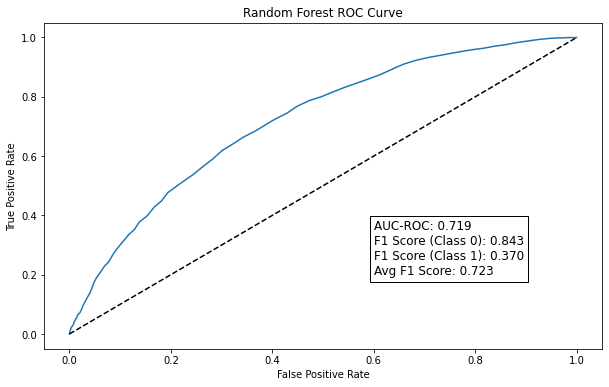

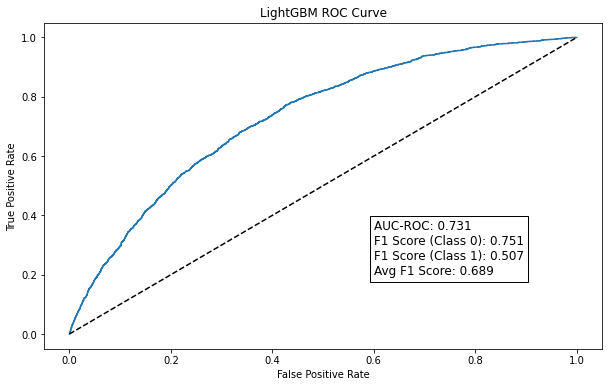

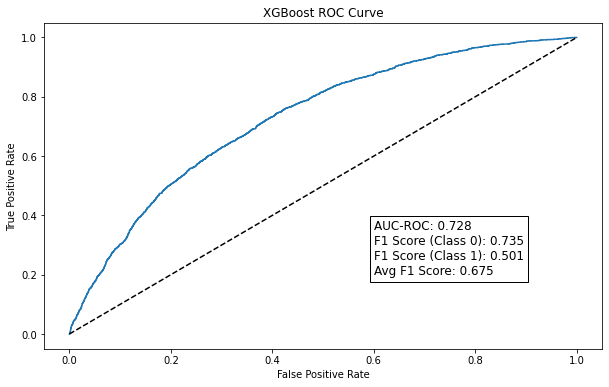

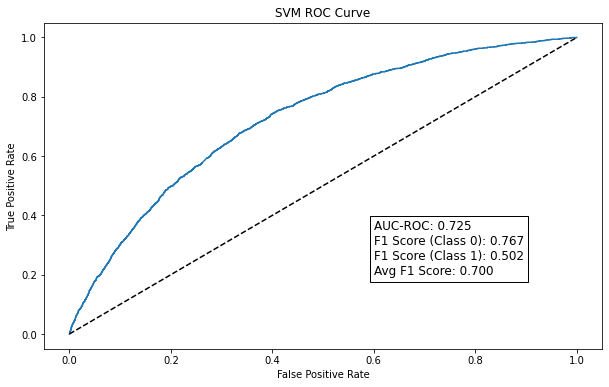

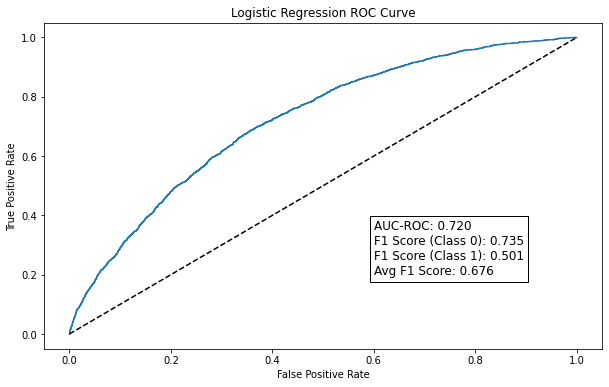

In [8]:
# Check if the Excel file already exists
file_exists = os.path.isfile(f'general_model_{feat}_{balancing_tech}.xlsx')

# If the file doesn't exist, create a new DataFrame to store the results
if not file_exists:
    results_df = pd.DataFrame(columns=[
        "timestamp",
        "Nr_of_ind._var",
        "Names_of_ind._var",
        "Target_0_count",
        "Target_1_count",
        "Model_name",
        "Balancing_tech.",
        "AUCROC",
        "CV_AUCROC",
        "CV_AUCROC_std",
        "AVG_F1",
        "F1_score_0",
        "F1_score_1",
        "Precision_0",
        "Precision_1",
        "Recall_0",
        "Recall_1",
        "Comment_1"
    ])
else:
    # If the file exists, load the existing DataFrame from the file
    results_df = pd.read_excel(f'general_model_{feat}_{balancing_tech}.xlsx')

rf_model = RandomForestClassifier(random_state=rs)
lgbm_model = LGBMClassifier(random_state=rs)
svm_model = SVC(kernel='rbf', probability=True, random_state=rs)
xgb_model = xgb.XGBClassifier(random_state=rs)
lr_model = LogisticRegression(max_iter=1000, random_state=rs)

models = [rf_model, lgbm_model, xgb_model, svm_model, lr_model]  
model_names = ['Random Forest', 'LightGBM', 'XGBoost', 'SVM','Logistic Regression'] 

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs)   

for i, model in enumerate(models):
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_prob)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    f1_class_0 = f1_score(y_test, y_pred, pos_label=0)
    f1_class_1 = f1_score(y_test, y_pred, pos_label=1)
    avg_f1 = f1_score(y_test, y_pred, average='weighted')
    
    precision_class_0 = precision_score(y_test, y_pred, pos_label=0)
    precision_class_1 = precision_score(y_test, y_pred, pos_label=1)
    recall_class_0 = recall_score(y_test, y_pred, pos_label=0)
    recall_class_1 = recall_score(y_test, y_pred, pos_label=1)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(model_names[i] + ' ROC Curve')
    plt.text(0.6, 0.2, f"AUC-ROC: {auc_roc:.3f}\nF1 Score (Class 0): {f1_class_0:.3f}\nF1 Score (Class 1): {f1_class_1:.3f}\nAvg F1 Score: {avg_f1:.3f}", fontsize=12, bbox=dict(facecolor='white'))
    plt.show()

    try:
        balancing_tech = balancing_tech
    except NameError:
        balancing_tech = None
    try:
        comment1 = comment1
    except NameError:
        comment1 = None

    # Create a dictionary of results
    result = {
        "timestamp": datetime.datetime.now(),
        "Nr_of_ind._var": nr_of_independent_var,
        "Names_of_ind._var": ", ".join(independent_var_names),
        "Target_0_count": y_train.value_counts()[0],
        "Target_1_count": target_1,
        "Model_name": model_names[i],
        "Balancing_tech.": balancing_tech,
        "AUCROC": auc_roc,
        "CV_AUCROC": np.mean(cv_scores),
        "CV_AUCROC_std": np.std(cv_scores),
        "AVG_F1": avg_f1,
        "F1_score_0": f1_class_0,
        "F1_score_1": f1_class_1,
        "Precision_0": precision_class_0,
        "Precision_1": precision_class_1,
        "Recall_0": recall_class_0,
        "Recall_1": recall_class_1,
        "Comment_1": comment1
    }

    # Append the result to the results DataFrame
    results_df = pd.concat([results_df, pd.DataFrame(result, index=[0])], ignore_index=True)

# Save the results DataFrame to the Excel file
results_df.to_excel(f'general_model_{feat}_{balancing_tech}.xlsx', index=False)

In [9]:
os.chdir('/Users/Mario/OneDrive/Desktop/Final code for thesis')
df = pd.read_csv("data.csv", dtype = datatypes, encoding='latin-1', index_col=0)
df = df.drop(columns= ['date', 'time', 'datetime', 'time_ESAW', 'lost_days', 'type_of_injury', 'injured_bodypart', 'general_profession_class', 'business_sector', 'severity'])

In [10]:
# --------------------------------------------------------------------------------
#TRAINING ON SIGNIFICANT FEATURES
# --------------------------------------------------------------------------------

df_copy = df.copy()

def encode_categorical(df, categorical_columns):
    le = LabelEncoder()
    for col in categorical_columns:
        df[col] = le.fit_transform(df[col])
    return df

categorical_columns = df.select_dtypes(include='object').columns.tolist()
df_encoded = encode_categorical(df, categorical_columns)

# Get the column names with 'int32' and 'int64' dtypes
int32_columns = df_encoded.select_dtypes(include='int32').columns.tolist()
int64_columns = df_encoded.select_dtypes(include='int64').columns.tolist()

# Combine the two lists to create the categorical_columns list
categorical_columns = int32_columns + int64_columns

def chi_squared_test(df, target, categorical_columns):
    significant_features = []
    for col in categorical_columns:
        contingency_table = pd.crosstab(df[col], df[target])
        chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
        
        if p_value < 0.05:
            significant_features.append(col)
    
    return significant_features

significant_chi2_features = chi_squared_test(df_encoded, 'target', categorical_columns)


def kendall_correlation(df, target, numerical_columns):
    significant_features = []
    for col in numerical_columns:
        kendall_tau, p_value = stats.kendalltau(df[col], df[target])
        
        if p_value < 0.05:
            significant_features.append(col)
    
    return significant_features

numerical_columns = df.select_dtypes(include='float64').columns.tolist()
significant_kendall_features = kendall_correlation(df, 'target', numerical_columns)

significant_features = significant_chi2_features + significant_kendall_features

df = df_copy[significant_features]

df.info()

nr_of_independent_var = len(df.columns) - 1
independent_var_names = [col for col in df.columns if col != 'target']

# Encode categorical features with no order
all_object_cols = list(df.select_dtypes(include=['object']).columns)
df = pd.get_dummies(df, columns=all_object_cols)

# Separate independent variables and dependent variable for train set
X = df.drop(columns=['target'])
y = df['target']

# Balance the target class using random over-sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale float64 variables
float_cols = X_train.select_dtypes(include='float64').columns.tolist()
scaler = MinMaxScaler(feature_range=(0,1))
X_train[float_cols] = scaler.fit_transform(X_train[float_cols])
X_test[float_cols] = scaler.transform(X_test[float_cols])

feat = 'significant_features'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48845 entries, 0 to 48844
Data columns (total 40 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   business_area                   48845 non-null  object 
 1   sex                             48845 non-null  object 
 2   employment_status               48845 non-null  object 
 3   location                        48845 non-null  object 
 4   citizenship                     48845 non-null  object 
 5   profession_code                 48845 non-null  object 
 6   workstation                     48845 non-null  object 
 7   working_environment             48845 non-null  object 
 8   working_process                 48845 non-null  object 
 9   specific_physical_activity      48845 non-null  object 
 10  material_agent_of_physical_act  48845 non-null  object 
 11  deviation                       48845 non-null  object 
 12  material_agent_of_deviation     

In [11]:
# Balance the target class using random over-sampling
target_1 = y_train.value_counts()[1]

rs = 42
over_sampler = RandomOverSampler(random_state=rs)
X_train, y_train = over_sampler.fit_resample(X_train, y_train)
balancing_tech = 'ROS'

""" under_sampler = RandomUnderSampler(random_state=rs)
X_train, y_train = under_sampler.fit_resample(X_train, y_train)
balancing_tech = 'RUS' """

""" smote = SMOTE(random_state=rs)
X_train, y_train = smote.fit_resample(X_train, y_train)
balancing_tech = 'SMOTE' """


""" balancing_tech = 'Unbalanced' """

" balancing_tech = 'Unbalanced' "

In [12]:
comment1 = f'General model; {feat} features; {balancing_tech}'

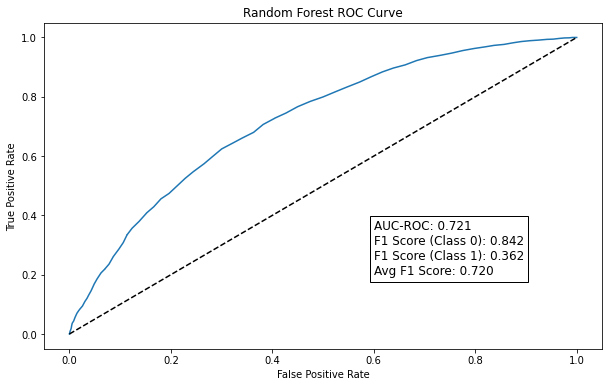

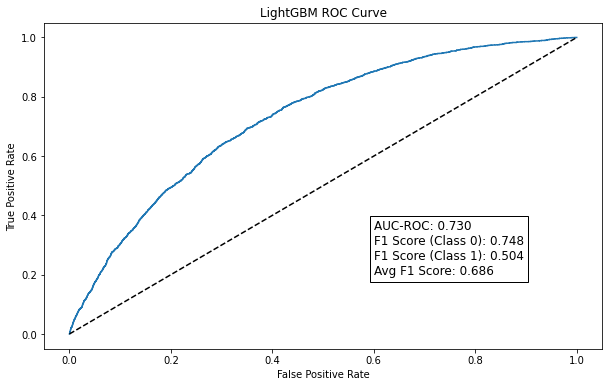

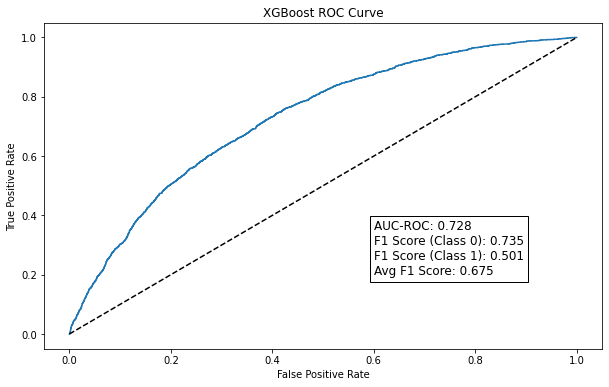

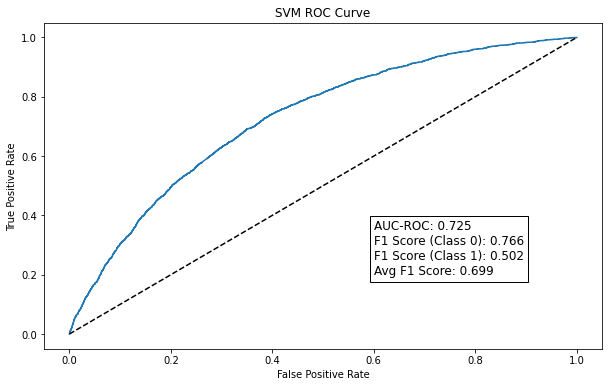

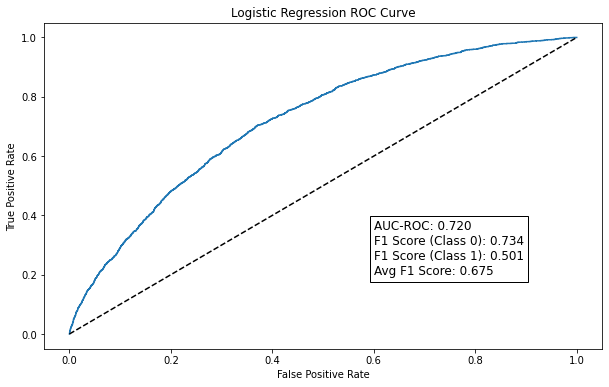

In [13]:
# Check if the Excel file already exists
file_exists = os.path.isfile(f'general_model_{feat}_{balancing_tech}.xlsx')

# If the file doesn't exist, create a new DataFrame to store the results
if not file_exists:
    results_df = pd.DataFrame(columns=[
        "timestamp",
        "Nr_of_ind._var",
        "Names_of_ind._var",
        "Target_0_count",
        "Target_1_count",
        "Model_name",
        "Balancing_tech.",
        "AUCROC",
        "CV_AUCROC",
        "CV_AUCROC_std",
        "AVG_F1",
        "F1_score_0",
        "F1_score_1",
        "Precision_0",
        "Precision_1",
        "Recall_0",
        "Recall_1",
        "Comment_1"
    ])
else:
    # If the file exists, load the existing DataFrame from the file
    results_df = pd.read_excel(f'general_model_{feat}_{balancing_tech}.xlsx')

rf_model = RandomForestClassifier(random_state=rs)
lgbm_model = LGBMClassifier(random_state=rs)
svm_model = SVC(kernel='rbf', probability=True, random_state=rs)
xgb_model = xgb.XGBClassifier(random_state=rs)
lr_model = LogisticRegression(max_iter=1000, random_state=rs)

models = [rf_model, lgbm_model, xgb_model, svm_model, lr_model]  
model_names = ['Random Forest', 'LightGBM', 'XGBoost', 'SVM','Logistic Regression'] 

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs)   

for i, model in enumerate(models):
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_prob)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    f1_class_0 = f1_score(y_test, y_pred, pos_label=0)
    f1_class_1 = f1_score(y_test, y_pred, pos_label=1)
    avg_f1 = f1_score(y_test, y_pred, average='weighted')
    
    precision_class_0 = precision_score(y_test, y_pred, pos_label=0)
    precision_class_1 = precision_score(y_test, y_pred, pos_label=1)
    recall_class_0 = recall_score(y_test, y_pred, pos_label=0)
    recall_class_1 = recall_score(y_test, y_pred, pos_label=1)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(model_names[i] + ' ROC Curve')
    plt.text(0.6, 0.2, f"AUC-ROC: {auc_roc:.3f}\nF1 Score (Class 0): {f1_class_0:.3f}\nF1 Score (Class 1): {f1_class_1:.3f}\nAvg F1 Score: {avg_f1:.3f}", fontsize=12, bbox=dict(facecolor='white'))
    plt.show()

    try:
        balancing_tech = balancing_tech
    except NameError:
        balancing_tech = None
    try:
        comment1 = comment1
    except NameError:
        comment1 = None

    # Create a dictionary of results
    result = {
        "timestamp": datetime.datetime.now(),
        "Nr_of_ind._var": nr_of_independent_var,
        "Names_of_ind._var": ", ".join(independent_var_names),
        "Target_0_count": y_train.value_counts()[0],
        "Target_1_count": target_1,
        "Model_name": model_names[i],
        "Balancing_tech.": balancing_tech,
        "AUCROC": auc_roc,
        "CV_AUCROC": np.mean(cv_scores),
        "CV_AUCROC_std": np.std(cv_scores),
        "AVG_F1": avg_f1,
        "F1_score_0": f1_class_0,
        "F1_score_1": f1_class_1,
        "Precision_0": precision_class_0,
        "Precision_1": precision_class_1,
        "Recall_0": recall_class_0,
        "Recall_1": recall_class_1,
        "Comment_1": comment1
    }

    # Append the result to the results DataFrame
    results_df = pd.concat([results_df, pd.DataFrame(result, index=[0])], ignore_index=True)

# Save the results DataFrame to the Excel file
results_df.to_excel(f'general_model_{feat}_{balancing_tech}.xlsx', index=False)

In [14]:
for i in range(5):
    winsound.Beep(440, 1000)